# Deep Learning for Deciphering Traffic Signs
# CNN Notebook
_________________________________________________________________________________________________________________________________________________________________________________

##### Contributors:
 Victor Floriano, Yifan Fan, Jose Salerno

## Problem Statement & Motivation
As the world advances towards autonomous vehicles, our team has observed the remarkable efforts of large car manufacturers, who are working with data scientists to develop fully autonomous cars. Our team is excited to contribute to the development of this technology by creating a neural network model that will be able to classify different traffic signs. Our ultimate goal is to assist car makers in overcoming the challenges they may face in implementing neural network models that effectively read traffic signs and further their efforts toward a fully autonomous car or assisted driving. We believe autonomous driving to be an important problem to solve due to the great economic benefits it can generate for car manufacturers and the improvement of general driving safety.

## Data Preparation
 We've selected the German Traffic Sign Recognition Benchmark (GTSRB) as our primary dataset. It's renowned for its complexity, featuring over 50,000 images across more than 40 classes of traffic signs. The GTSRB is publicly accessible through two resources. To efficiently manage the extensive and complex GTSRB dataset, our strategy integrates preprocessing for uniformity, data augmentation for robustness, and batch processing for computational efficiency. We'll employ distributed computing to parallelize operations, enhancing processing speed, and use stratified sampling for quick experimentation without compromising representativeness.



---





# CNN - Models

 The provided code outlines the construction and operation of a convolutional neural network (CNN) designed for image classification, implemented using PyTorch. The process starts with data preprocessing, where image data undergoes resizing, tensor conversion, and normalization of the training dataset.

The CNN architecture comprises multiple layers such as batch normalization and ReLU activation functions, dropout layers, and max pooling layers. Following feature extraction, the network transitions to a classifier linear layer to create predictions across 43 classes.

________________________________________________________________________________________________________________________________________________

Results:

- Model 1: Validation Accuracy = 98.99%
- **Model 2: Validation Accuracy = 99.07% (Best Model)**
- Model 3: Validation Accuracy = 97.65%
- Model 4: Validation Accuracy = 87.41%
- Model 5: Validation Accuracy = 89.38%
- Model 6: Validation Accuracy = 90.38%

____________

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, random_split
import tensorflow as tf
import os
import cv2
from PIL import Image
import seaborn as sns
import time
import datetime

In [2]:
enable_wandb = True
use_gpu = True
gpu_available = torch.cuda.is_available()
gpu_available

True

In [3]:
if enable_wandb:
  !pip install wandb -qU
  import wandb
  wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.2 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
!unzip /content/Train.zip

In [ ]:
!unzip /content/Test_organized.zip

### Data

In [9]:
import os

def count_images_per_category(directory):
    category_image_count = {}

    # Iterate over each item in the specified directory.
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)

        # Check if the current path is a directory.
        if os.path.isdir(category_path):
            num_images = len([item for item in os.listdir(category_path) if item.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))])
            category_image_count[category] = num_images

    return category_image_count

dataset_directory = 'Train'
image_counts = count_images_per_category(dataset_directory)
# Sort the categories numerically
sorted_train = {key: image_counts[key] for key in sorted(image_counts.keys(), key=lambda x: int(x))}
print(sorted_train)

# Calculate the total number of images across all categories
total_train = sum(sorted_train.values())
print(f"Total images across all categories for training: {total_train}")

{'00': 210, '01': 2220, '02': 2250, '03': 1410, '04': 1980, '05': 1860, '06': 430, '07': 1440, '08': 1410, '09': 1470, '10': 2010, '11': 1320, '12': 2100, '13': 2160, '14': 780, '15': 630, '16': 420, '17': 1110, '18': 1200, '19': 210, '20': 360, '21': 330, '22': 390, '23': 510, '24': 270, '25': 1500, '26': 600, '27': 240, '28': 540, '29': 270, '30': 450, '31': 780, '32': 240, '33': 689, '34': 420, '35': 1200, '36': 390, '37': 210, '38': 2070, '39': 300, '40': 360, '41': 240, '42': 240}
Total images across all categories for training: 39219


In [10]:
dataset_directory = 'Test_organized'
image_counts = count_images_per_category(dataset_directory)
sorted_test = {key: image_counts[key] for key in sorted(image_counts.keys(), key=lambda x: int(x))}

print(sorted_test)
total_test = sum(sorted_test.values())
print(f"Total images across all categories for testing: {total_test}")

{'0': 60, '1': 720, '2': 750, '3': 450, '4': 660, '5': 630, '6': 150, '7': 450, '8': 450, '9': 480, '10': 660, '11': 420, '12': 690, '13': 720, '14': 270, '15': 210, '16': 150, '17': 360, '18': 390, '19': 60, '20': 90, '21': 90, '22': 120, '23': 150, '24': 90, '25': 480, '26': 180, '27': 60, '28': 150, '29': 90, '30': 150, '31': 270, '32': 60, '33': 210, '34': 120, '35': 390, '36': 120, '37': 60, '38': 690, '39': 90, '40': 90, '41': 60, '42': 90}
Total images across all categories for testing: 12630


In [11]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), (0.2672, 0.2564, 0.2629))
])

dataset_train = ImageFolder(
    'Train',
    transform = train_transforms
)
dataset_test = ImageFolder(
    'Test_organized',
    transform = train_transforms
)

In [12]:
train_data, val_data = random_split(dataset_train, [0.8, 0.2])

### CNN Model - 1

- Epochs = 100
- Batch size = 64
- Learning Rates = 0.001
- No Data Agumentation
- No Class Balancing
- Early Stopping Patience 5

In [13]:
wandb.init(project="Project CNN_v1", name = 'experiment_v1')

wandb: Currently logged in as: victorgf (victorgfloriano). Use `wandb login --relogin` to force relogin


In [14]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(dataset_test, shuffle=True, batch_size = 64, num_workers = 2)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary


class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Feature extraction layers
        self.features = nn.Sequential(
            # First convolutional layer taking 3 input channels (RGB image) and outputting 64 feature maps
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),  # Normalize the output of the previous layer to improve training speed and stability
            nn.ReLU(inplace=True),  # Non-linear activation function (ReLU)
            nn.Dropout2d(0.2),  # Dropout to prevent overfitting by randomly zeroing some of the elements of the input tensor

            nn.MaxPool2d(kernel_size=2),  # Max pooling with a kernel size of 2 to reduce spatial dimensions
            # Second convolutional layer, increasing the depth to 192
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),  # Batch normalization
            nn.ReLU(inplace=True),  # ReLU activation
            nn.Dropout2d(0.3),  # Increasing dropout rate for more regularization

            nn.MaxPool2d(kernel_size=2),  # Another max pooling step
            # Third convolutional layer with increased depth to 384
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),  # Batch normalization
            nn.ReLU(inplace=True),  # ReLU activation
            nn.Dropout2d(0.4),  # Further increase in dropout for regularization

            # Fourth convolutional layer maintaining depth at 256
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),  # Batch normalization
            nn.ReLU(inplace=True),  # ReLU activation

            # Fifth convolutional layer also at 256 depth
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),  # Batch normalization
            nn.ReLU(inplace=True),  # ReLU activation
            nn.MaxPool2d(kernel_size=2),  # Max pooling
            nn.Dropout2d(0.5)  # Final dropout layer to maximize regularization before classification
            )

        # Classification layers
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Dropout before any dense layers
            nn.Linear(256 * 2 * 2, 1000),  # Fully connected layer reducing dimensionality to 1000
            nn.ReLU(inplace=True),  # ReLU activation
            nn.Dropout(0.5),  # Additional dropout for regularization
            nn.Linear(in_features=1000, out_features=256),  # Further reducing dimensionality to 256
            nn.ReLU(inplace=True),  # ReLU activation
            nn.Linear(256, num_classes)  # Final output layer with number of classes as output size
            )

    def forward(self, x):
        # Forward pass definition
        x = self.features(x)  # Apply feature extractor
        x = x.view(x.size(0), -1)  # Flatten the output of the convolutional layers
        x = self.classifier(x)  # Apply classifier
        return x


In [21]:
net = Net(num_classes=43)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

# Print a summary of the network; this shows the architecture and parameter count for an input size of (3, 32, 32)
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,792
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         Dropout2d-4           [-1, 64, 16, 16]               0
         MaxPool2d-5             [-1, 64, 8, 8]               0
            Conv2d-6            [-1, 192, 8, 8]         110,784
       BatchNorm2d-7            [-1, 192, 8, 8]             384
              ReLU-8            [-1, 192, 8, 8]               0
         Dropout2d-9            [-1, 192, 8, 8]               0
        MaxPool2d-10            [-1, 192, 4, 4]               0
           Conv2d-11            [-1, 384, 4, 4]         663,936
      BatchNorm2d-12            [-1, 384, 4, 4]             768
             ReLU-13            [-1, 384, 4, 4]               0
        Dropout2d-14            [-1, 38

In [16]:
wandb.config.update({
    "learning_rate": 0.001,
    "epochs": 100,
    "batch_size": 64
})
wandb.watch(net)

In [17]:
class EarlyStopper:
    def __init__(self, patience=1, delta=0):
        # Initialization of the EarlyStopper
        self.patience = patience  # Number of epochs with no improvement after which training will be stopped
        self.delta = delta  # Minimum change in the monitored quantity to qualify as an improvement
        self.counter = 0  # Counter for the epochs with no improvement
        self.min_validation_loss = float('inf')  # Initialize the minimum validation loss as infinity
        self.best_model = None  # To store the best model's weights

    def early_stop(self, validation_loss, model):
        # Check if early stopping is needed
        if validation_loss < self.min_validation_loss - self.delta:
            # Improvement found, update minimum loss and reset counter
            self.min_validation_loss = validation_loss  # Update the minimum validation loss
            self.counter = 0  # Reset the no-improvement counter
            self.best_model = model.state_dict()  # Save the current best model's weights
        elif validation_loss >= self.min_validation_loss - self.delta:
            # No improvement, increment the counter
            self.counter += 1  # Increment the no-improvement counter
            if self.counter >= self.patience:
                # Patience exceeded, load the best model and stop training
                model.load_state_dict(self.best_model)  # Load the best model's state
                return True  # Return True to indicate that training should stop
        return False  # Return False to indicate that training should continue


In [18]:
def get_loss(loader, model, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()  # Sum up batch loss

    average_loss = total_loss / len(loader)
    return average_loss


In [19]:
def get_accuracy(dataloader, model, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [22]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
early_stopping = EarlyStopper(patience=5,delta = 0.01)

In [ ]:
epochs = 100
model = net
for epoch in range(epochs):
    # Training phase
    model.train()  # Set the model to training mode (activates dropout, batch norm etc.)
    for i, (images, labels) in enumerate(train_loader):  # Iterate over batches of data from the training loader
        images, labels = images.to(device), labels.to(device)  # Move the data to the appropriate device (GPU or CPU)
        optimizer.zero_grad()  # Clear the gradients of all optimized variables
        outputs = model(images)  # Forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(outputs, labels)  # Calculate the batch's loss using the defined loss criterion
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)

        if i % 100 == 0:  # Every 100 batches, print the training loss
           print("Epoch", epoch + 1, " batch", i + 1, ". Training Loss: ", loss.item())  # Display the current epoch, batch, and loss
           if enable_wandb:
            wandb.log({"loss": loss})
        wandb.log({"train_loss":loss.item()})

    # Validation phase
    model.eval()  # Set the model to evaluation mode (deactivates dropout, batch norm etc.)
    validation_loss = get_loss(val_loader, model, criterion, device)  # Compute the total loss over all validation data
    validation_accuracy = get_accuracy(val_loader, model, device)  # Compute the accuracy over all validation data

    print(f'Epoch {epoch+1}: Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%')  # Display validation results

    # Check for early stopping
    if early_stopping.early_stop(validation_loss, model):  # If the early stopping condition is met
        print("Early stopping triggered.")  # Print a message indicating that early stopping has been triggered
        break  # Exit the training loop
wandb.finish()


Epoch 1  batch 1 . Training Loss:  3.740623712539673
Epoch 1  batch 101 . Training Loss:  3.2844128608703613
Epoch 1  batch 201 . Training Loss:  2.627850294113159
Epoch 1  batch 301 . Training Loss:  2.0726101398468018
Epoch 1  batch 401 . Training Loss:  2.0345070362091064
Epoch 1: Validation Loss: 1.6195, Validation Accuracy: 42.10%
Epoch 2  batch 1 . Training Loss:  1.851232886314392
Epoch 2  batch 101 . Training Loss:  1.8435171842575073
Epoch 2  batch 201 . Training Loss:  1.7504080533981323
Epoch 2  batch 301 . Training Loss:  1.6081430912017822
Epoch 2  batch 401 . Training Loss:  1.6278976202011108
Epoch 2: Validation Loss: 1.2251, Validation Accuracy: 56.70%
Epoch 3  batch 1 . Training Loss:  1.5973659753799438
Epoch 3  batch 101 . Training Loss:  1.3043276071548462
Epoch 3  batch 201 . Training Loss:  1.249068260192871
Epoch 3  batch 301 . Training Loss:  1.0592491626739502
Epoch 3  batch 401 . Training Loss:  0.9640299677848816
Epoch 3: Validation Loss: 0.7157, Validation A

loss,█▆▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▅▄▄▃▃▃▂▂▁▂▂▂▁▂▁▁▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▇▇▇█████████████████
val_loss,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.08109
train_loss,0.00345
val_accuracy,98.99248
val_loss,0.03599


------------------------------------------------------------------------

### CNN Model - 2

- Epochs = 25
- Batch size = 128
- Learning Rates = 0.001
- No Data Agumentation
- No Class Balancing
- Early Stopping Patience 5

In [40]:
wandb.init(project="Project CNN_v1", name = 'experiment_v2')

In [41]:
wandb.config.update({
    "learning_rate": 0.001,
    "epochs": 25,
    "batch_size": 128
})
#wandb.watch(net)

In [42]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(dataset_test, shuffle=True, batch_size = 128, num_workers = 2)

In [43]:
net1 = Net(num_classes=43)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net1.to(device)

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Dropout2d(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Dropout2d(p=0.4, inplace=False)
    (14): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchN

In [44]:
optimizer = optim.Adam(net1.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
early_stopping = EarlyStopper(patience=5,delta = 0.01)

In [45]:
epochs = 25
model = net1
for epoch in range(epochs):
    # Training loop
    model.train()
    for i,(images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if i %100 == 0:
          print("Epoch", epoch+ 1, " batch", i+1, ". Training Loss: ", loss.item())
          if enable_wandb:
            wandb.log({"loss": loss})
        wandb.log({"train_loss":loss.item()})

    # Validation loop
    model.eval()
    validation_loss = get_loss(val_loader, model, criterion, device)
    validation_accuracy = get_accuracy(val_loader, model, device)
    wandb.log({"val_loss": validation_loss, "val_accuracy": validation_accuracy})

    print(f'Epoch {epoch+1}: Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%')

    if early_stopping.early_stop(validation_loss, model):
        print("Early stopping triggered.")
        break
wandb.finish()


Epoch 1  batch 1 . Training Loss:  3.821024179458618
Epoch 1  batch 101 . Training Loss:  3.041100025177002
Epoch 1  batch 201 . Training Loss:  2.0927741527557373
Epoch 1: Validation Loss: 1.7282, Validation Accuracy: 40.12%
Epoch 2  batch 1 . Training Loss:  1.925767421722412
Epoch 2  batch 101 . Training Loss:  1.5803276300430298
Epoch 2  batch 201 . Training Loss:  1.4171875715255737
Epoch 2: Validation Loss: 1.1989, Validation Accuracy: 55.37%
Epoch 3  batch 1 . Training Loss:  1.299289345741272
Epoch 3  batch 101 . Training Loss:  1.2329710721969604
Epoch 3  batch 201 . Training Loss:  0.966637372970581
Epoch 3: Validation Loss: 0.7441, Validation Accuracy: 71.71%
Epoch 4  batch 1 . Training Loss:  1.026353120803833
Epoch 4  batch 101 . Training Loss:  0.8358721137046814
Epoch 4  batch 201 . Training Loss:  0.5898396968841553
Epoch 4: Validation Loss: 0.4313, Validation Accuracy: 84.51%
Epoch 5  batch 1 . Training Loss:  0.7062411904335022
Epoch 5  batch 101 . Training Loss:  0.6

loss,█▇▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▅▄▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▆▇▇███████████████████
val_loss,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.06275
train_loss,0.00022
val_accuracy,99.19674
val_loss,0.0358


---------------------------------

### CNN Model - 3

- Epochs = 25
- Batch size = 128
- Learning Rates = 0.001
- No Data Agumentation
- Class Balancing
- Early Stopping Patience 5

In [ ]:
wandb.init(project="Project CNN_v1", name = 'experiment_v3')

In [ ]:
wandb.config.update({
    "learning_rate": 0.001,
    "epochs": 25,
    "batch_size": 128
})
wandb.watch(net)

[]

In [ ]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(dataset_test, shuffle=True, batch_size = 128, num_workers = 2)

In [ ]:
net2 = Net(num_classes=43)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net2.to(device)

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Dropout2d(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Dropout2d(p=0.4, inplace=False)
    (14): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchN

In [ ]:
weights = [total_train/sorted_train[str(i).zfill(2)] if str(i).zfill(2) in sorted_train else 1 for i in range(43)]
class_weights = torch.FloatTensor(weights).cuda()

In [ ]:
optimizer = optim.Adam(net2.parameters(), lr=0.001)
early_stopping = EarlyStopper(patience=5,delta = 0.01)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
epochs = 25
model = net2
for epoch in range(epochs):
    # Training loop
    model.train()
    for i,(images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if i %100 == 0:
          print("Epoch", epoch+ 1, " batch", i+1, ". Training Loss: ", loss.item())
          if enable_wandb:
            wandb.log({"loss": loss})
        wandb.log({"train_loss":loss.item()})

    # Validation loop
    model.eval()
    validation_loss = get_loss(val_loader, model, criterion, device)
    validation_accuracy = get_accuracy(val_loader, model, device)
    wandb.log({"val_loss": validation_loss, "val_accuracy": validation_accuracy})

    print(f'Epoch {epoch+1}: Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%')

    if early_stopping.early_stop(validation_loss, model):
        print("Early stopping triggered.")
        break
wandb.finish()


Epoch 1  batch 1 . Training Loss:  3.7736706733703613
Epoch 1  batch 101 . Training Loss:  3.5578105449676514
Epoch 1  batch 201 . Training Loss:  3.195345163345337
Epoch 1: Validation Loss: 3.0196, Validation Accuracy: 5.17%
Epoch 2  batch 1 . Training Loss:  2.9793307781219482
Epoch 2  batch 101 . Training Loss:  2.6133809089660645
Epoch 2  batch 201 . Training Loss:  2.442598342895508
Epoch 2: Validation Loss: 2.0729, Validation Accuracy: 29.78%
Epoch 3  batch 1 . Training Loss:  2.336299419403076
Epoch 3  batch 101 . Training Loss:  2.1039879322052
Epoch 3  batch 201 . Training Loss:  2.08070969581604
Epoch 3: Validation Loss: 1.6997, Validation Accuracy: 39.69%
Epoch 4  batch 1 . Training Loss:  1.8897264003753662
Epoch 4  batch 101 . Training Loss:  2.063704490661621
Epoch 4  batch 201 . Training Loss:  1.7049708366394043
Epoch 4: Validation Loss: 1.2603, Validation Accuracy: 50.34%
Epoch 5  batch 1 . Training Loss:  1.4017705917358398
Epoch 5  batch 101 . Training Loss:  1.46445

loss,██▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▅▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▄▅▆▆▇▇▇▇██████████████
val_loss,█▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.18455
train_loss,0.01202
val_accuracy,97.65336
val_loss,0.05779


---------------------

### CNN Model - 4

- Epochs = 50
- Batch size = 128
- Learning Rates = 0.001
- Data Agumentation
- Class Balancing
- Early Stopping Patience 5

In [ ]:
wandb.init(project="Project CNN_v1", name = 'experiment_v4')

In [ ]:
wandb.config.update({
    "learning_rate": 0.001,
    "epochs": 50,
    "batch_size": 128
})

In [ ]:
train_transform_1 = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), (0.2672, 0.2564, 0.2629))
])

In [ ]:
dataset_train = ImageFolder(
    'Train',
    transform = train_transform_1
)

train_data, val_data = random_split(dataset_train, [0.8, 0.2])

In [ ]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(dataset_test, shuffle=True, batch_size = 128, num_workers = 2)

In [ ]:
net3 = Net(num_classes=43)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net3.to(device)

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Dropout2d(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Dropout2d(p=0.4, inplace=False)
    (14): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchN

In [ ]:
optimizer = optim.Adam(net3.parameters(), lr=0.001)
early_stopping = EarlyStopper(patience=5,delta = 0.01)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
epochs = 50
model = net3
for epoch in range(epochs):
    # Training loop
    model.train()
    for i,(images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if i %100 == 0:
          print("Epoch", epoch+ 1, " batch", i+1, ". Training Loss: ", loss.item())
          if enable_wandb:
            wandb.log({"loss": loss})
        wandb.log({"train_loss":loss.item()})

    # Validation loop
    model.eval()
    validation_loss = get_loss(val_loader, model, criterion, device)
    validation_accuracy = get_accuracy(val_loader, model, device)
    wandb.log({"val_loss": validation_loss, "val_accuracy": validation_accuracy})

    print(f'Epoch {epoch+1}: Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%')

    if early_stopping.early_stop(validation_loss, model):
        print("Early stopping triggered.")
        break
wandb.finish()

Epoch 1  batch 1 . Training Loss:  3.8147876262664795
Epoch 1  batch 101 . Training Loss:  3.5149896144866943
Epoch 1  batch 201 . Training Loss:  3.3080899715423584
Epoch 1: Validation Loss: 2.8435, Validation Accuracy: 8.86%
Epoch 2  batch 1 . Training Loss:  2.7447104454040527
Epoch 2  batch 101 . Training Loss:  2.8544790744781494
Epoch 2  batch 201 . Training Loss:  2.420358657836914
Epoch 2: Validation Loss: 2.2796, Validation Accuracy: 21.16%
Epoch 3  batch 1 . Training Loss:  2.4717936515808105
Epoch 3  batch 101 . Training Loss:  2.3563475608825684
Epoch 3  batch 201 . Training Loss:  2.222247362136841
Epoch 3: Validation Loss: 2.0543, Validation Accuracy: 25.69%
Epoch 4  batch 1 . Training Loss:  2.1091411113739014
Epoch 4  batch 101 . Training Loss:  2.2933366298675537
Epoch 4  batch 201 . Training Loss:  2.1197264194488525
Epoch 4: Validation Loss: 1.8142, Validation Accuracy: 34.61%
Epoch 5  batch 1 . Training Loss:  1.878069519996643
Epoch 5  batch 101 . Training Loss:  1

Epoch 36: Validation Loss: 0.3294, Validation Accuracy: 82.72%
Epoch 37  batch 1 . Training Loss:  0.45854634046554565
Epoch 37  batch 101 . Training Loss:  0.42244046926498413
Epoch 37  batch 201 . Training Loss:  0.6222683191299438
Epoch 37: Validation Loss: 0.3092, Validation Accuracy: 84.29%
Epoch 38  batch 1 . Training Loss:  0.3853470981121063
Epoch 38  batch 101 . Training Loss:  0.5691140294075012
Epoch 38  batch 201 . Training Loss:  0.4466889798641205
Epoch 38: Validation Loss: 0.3283, Validation Accuracy: 82.64%
Epoch 39  batch 1 . Training Loss:  0.4012397229671478
Epoch 39  batch 101 . Training Loss:  0.46965929865837097
Epoch 39  batch 201 . Training Loss:  0.46745169162750244
Epoch 39: Validation Loss: 0.3072, Validation Accuracy: 83.88%
Epoch 40  batch 1 . Training Loss:  0.6425666809082031
Epoch 40  batch 101 . Training Loss:  0.566315233707428
Epoch 40  batch 201 . Training Loss:  0.466322660446167
Epoch 40: Validation Loss: 0.2996, Validation Accuracy: 83.76%
Epoch 4

loss,█▆▅▅▄▄▄▃▃▂▃▃▂▂▃▂▂▂▁▂▂▂▂▂▁▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁
train_loss,█▆▆▅▅▄▃▄▃▃▃▄▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▂▂▁▁▂▁▁▁▁
val_accuracy,▁▂▂▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_loss,█▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.34472
train_loss,0.48425
val_accuracy,87.41232
val_loss,0.23001


---------------------

### CNN Model - 5

- Epochs = 100
- Batch size = 128
- Learning Rates = 0.001
- Data Agumentation
- Class Balancing
- Early Stopping Patience 5

In [ ]:
wandb.init(project="Project CNN_v1", name = 'experiment_v5')

In [ ]:
wandb.config.update({
    "learning_rate": 0.001,
    "epochs": 100,
    "batch_size": 128
})

In [ ]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(dataset_test, shuffle=True, batch_size = 128, num_workers = 2)

In [ ]:
net4 = Net(num_classes=43)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net4.to(device)

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Dropout2d(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Dropout2d(p=0.4, inplace=False)
    (14): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchN

In [ ]:
weights_normalized = [weight * len(sorted_train) / sum(weights) for weight in weights]
class_weights = torch.tensor(weights_normalized, dtype=torch.float32)
if torch.cuda.is_available():
    class_weights = class_weights.cuda()

In [ ]:
optimizer = optim.Adam(net4.parameters(), lr=0.001)
early_stopping = EarlyStopper(patience=5,delta = 0.01)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
epochs = 100
model = net4
for epoch in range(epochs):
    # Training loop
    model.train()
    for i,(images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if i %100 == 0:
          print("Epoch", epoch+ 1, " batch", i+1, ". Training Loss: ", loss.item())
          if enable_wandb:
            wandb.log({"loss": loss})
        wandb.log({"train_loss":loss.item()})

    # Validation loop
    model.eval()
    validation_loss = get_loss(val_loader, model, criterion, device)
    validation_accuracy = get_accuracy(val_loader, model, device)
    wandb.log({"val_loss": validation_loss, "val_accuracy": validation_accuracy})

    print(f'Epoch {epoch+1}: Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%')

    if early_stopping.early_stop(validation_loss, model):
        print("Early stopping triggered.")
        break
wandb.finish()

Epoch 1  batch 1 . Training Loss:  3.7799925804138184
Epoch 1  batch 101 . Training Loss:  3.462458848953247
Epoch 1  batch 201 . Training Loss:  2.818197011947632
Epoch 1: Validation Loss: 2.9514, Validation Accuracy: 8.23%
Epoch 2  batch 1 . Training Loss:  2.760685920715332
Epoch 2  batch 101 . Training Loss:  2.5269665718078613
Epoch 2  batch 201 . Training Loss:  2.2609143257141113
Epoch 2: Validation Loss: 2.2359, Validation Accuracy: 26.31%
Epoch 3  batch 1 . Training Loss:  2.2194390296936035
Epoch 3  batch 101 . Training Loss:  2.5049893856048584
Epoch 3  batch 201 . Training Loss:  2.280463695526123
Epoch 3: Validation Loss: 1.9806, Validation Accuracy: 33.39%
Epoch 4  batch 1 . Training Loss:  2.4278275966644287
Epoch 4  batch 101 . Training Loss:  2.079555034637451
Epoch 4  batch 201 . Training Loss:  2.0913970470428467
Epoch 4: Validation Loss: 1.8345, Validation Accuracy: 33.64%
Epoch 5  batch 1 . Training Loss:  1.8381377458572388
Epoch 5  batch 101 . Training Loss:  1.9

Epoch 36: Validation Loss: 0.3419, Validation Accuracy: 82.68%
Epoch 37  batch 1 . Training Loss:  0.629709780216217
Epoch 37  batch 101 . Training Loss:  0.7041293382644653
Epoch 37  batch 201 . Training Loss:  0.5941136479377747
Epoch 37: Validation Loss: 0.3293, Validation Accuracy: 83.03%
Epoch 38  batch 1 . Training Loss:  0.5397292971611023
Epoch 38  batch 101 . Training Loss:  0.4399472773075104
Epoch 38  batch 201 . Training Loss:  0.5783757567405701
Epoch 38: Validation Loss: 0.3276, Validation Accuracy: 83.34%
Epoch 39  batch 1 . Training Loss:  0.4393775761127472
Epoch 39  batch 101 . Training Loss:  0.7997291684150696
Epoch 39  batch 201 . Training Loss:  0.43415191769599915
Epoch 39: Validation Loss: 0.3153, Validation Accuracy: 83.28%
Epoch 40  batch 1 . Training Loss:  0.6963233947753906
Epoch 40  batch 101 . Training Loss:  0.6284853219985962
Epoch 40  batch 201 . Training Loss:  0.402750700712204
Epoch 40: Validation Loss: 0.3017, Validation Accuracy: 85.52%
Epoch 41  

loss,█▅▆▅▄▃▄▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁
train_loss,█▆▆▅▄▄▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▂▂▂▁▂▁▁▁▂▁▂▁
val_accuracy,▁▃▃▄▅▅▆▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
val_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.32521
train_loss,0.6436
val_accuracy,89.37636
val_loss,0.19973


-------------------------

### CNN Model - 6

- Epochs = 50
- Batch size = 128
- Learning Rates = 0.001
- Data Agumentation
- Class Balancing
- Early Stopping Patience 7

In [ ]:
wandb.init(project="Project CNN_v1", name = 'experiment_v6')

In [ ]:
wandb.config.update({
    "learning_rate": 0.001,
    "epochs": 50,
    "batch_size": 128,
})

In [ ]:
train_transform_1 = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), (0.2672, 0.2564, 0.2629))
])
dataset_train = ImageFolder(
    'Train',
    transform = train_transform_1)

train_data, val_data = random_split(dataset_train, [0.8, 0.2])
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(dataset_test, shuffle=True, batch_size = 128, num_workers = 2)

In [ ]:
net5 = Net(num_classes=43)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net5.to(device)

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Dropout2d(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Dropout2d(p=0.4, inplace=False)
    (14): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchN

In [ ]:
weights_normalized = [weight * len(sorted_train) / sum(weights) for weight in weights]
class_weights = torch.tensor(weights_normalized, dtype=torch.float32)
if torch.cuda.is_available():
    class_weights = class_weights.cuda()

In [ ]:
optimizer = optim.Adam(net5.parameters(), lr=0.001)
early_stopping = EarlyStopper(patience=7,delta = 0.01)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
epochs = 100
model = net5
for epoch in range(epochs):
    # Training loop
    model.train()
    for i,(images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if i %100 == 0:
          print("Epoch", epoch+ 1, " batch", i+1, ". Training Loss: ", loss.item())
          if enable_wandb:
            wandb.log({"loss": loss})
        wandb.log({"train_loss":loss.item()})

    # Validation loop
    model.eval()
    validation_loss = get_loss(val_loader, model, criterion, device)
    validation_accuracy = get_accuracy(val_loader, model, device)
    wandb.log({"val_loss": validation_loss, "val_accuracy": validation_accuracy})

    print(f'Epoch {epoch+1}: Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%')

    if early_stopping.early_stop(validation_loss, model):
        print("Early stopping triggered.")
        break
wandb.finish()

Epoch 1  batch 1 . Training Loss:  3.8933286666870117
Epoch 1  batch 101 . Training Loss:  3.487985134124756
Epoch 1  batch 201 . Training Loss:  3.0350165367126465
Epoch 1: Validation Loss: 2.7386, Validation Accuracy: 9.04%
Epoch 2  batch 1 . Training Loss:  2.8283674716949463
Epoch 2  batch 101 . Training Loss:  2.5068910121917725
Epoch 2  batch 201 . Training Loss:  2.461008310317993
Epoch 2: Validation Loss: 2.2643, Validation Accuracy: 23.79%
Epoch 3  batch 1 . Training Loss:  2.357834577560425
Epoch 3  batch 101 . Training Loss:  2.249356269836426
Epoch 3  batch 201 . Training Loss:  2.4024529457092285
Epoch 3: Validation Loss: 2.0437, Validation Accuracy: 32.98%
Epoch 4  batch 1 . Training Loss:  2.1649677753448486
Epoch 4  batch 101 . Training Loss:  2.267047882080078
Epoch 4  batch 201 . Training Loss:  1.7670679092407227
Epoch 4: Validation Loss: 1.7687, Validation Accuracy: 35.02%
Epoch 5  batch 1 . Training Loss:  2.073256731033325
Epoch 5  batch 101 . Training Loss:  2.01

Epoch 36: Validation Loss: 0.3379, Validation Accuracy: 82.82%
Epoch 37  batch 1 . Training Loss:  0.48224759101867676
Epoch 37  batch 101 . Training Loss:  0.5396406054496765
Epoch 37  batch 201 . Training Loss:  0.5639005303382874
Epoch 37: Validation Loss: 0.3288, Validation Accuracy: 82.83%
Epoch 38  batch 1 . Training Loss:  0.5898976922035217
Epoch 38  batch 101 . Training Loss:  0.5728935599327087
Epoch 38  batch 201 . Training Loss:  0.5638312101364136
Epoch 38: Validation Loss: 0.3251, Validation Accuracy: 82.74%
Epoch 39  batch 1 . Training Loss:  0.6789456009864807
Epoch 39  batch 101 . Training Loss:  0.7256856560707092
Epoch 39  batch 201 . Training Loss:  0.582680881023407
Epoch 39: Validation Loss: 0.3318, Validation Accuracy: 83.85%
Epoch 40  batch 1 . Training Loss:  0.7096741199493408
Epoch 40  batch 101 . Training Loss:  0.5494446754455566
Epoch 40  batch 201 . Training Loss:  0.43946805596351624
Epoch 40: Validation Loss: 0.3085, Validation Accuracy: 84.59%
Epoch 41

Epoch 72  batch 1 . Training Loss:  0.26299765706062317
Epoch 72  batch 101 . Training Loss:  0.3608761131763458
Epoch 72  batch 201 . Training Loss:  0.44342151284217834
Epoch 72: Validation Loss: 0.1754, Validation Accuracy: 90.32%
Epoch 73  batch 1 . Training Loss:  0.36048686504364014
Epoch 73  batch 101 . Training Loss:  0.34961360692977905
Epoch 73  batch 201 . Training Loss:  0.36577674746513367
Epoch 73: Validation Loss: 0.1560, Validation Accuracy: 91.07%
Epoch 74  batch 1 . Training Loss:  0.4020003080368042
Epoch 74  batch 101 . Training Loss:  0.4022863209247589
Epoch 74  batch 201 . Training Loss:  0.42391663789749146
Epoch 74: Validation Loss: 0.1651, Validation Accuracy: 90.95%
Epoch 75  batch 1 . Training Loss:  0.37245362997055054
Epoch 75  batch 101 . Training Loss:  0.3831147849559784
Epoch 75  batch 201 . Training Loss:  0.2977456748485565
Epoch 75: Validation Loss: 0.1687, Validation Accuracy: 90.38%
Early stopping triggered.


loss,█▆▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▂▁▁▁▁▁▂▁▁▁▁
train_loss,█▇▆▅▅▄▅▃▃▃▃▃▃▂▂▃▂▂▂▂▂▁▁▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▂
val_accuracy,▁▂▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇██████████████
val_loss,█▇▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.29775
train_loss,0.38454
val_accuracy,90.38388
val_loss,0.1687


-------------------

## CNN(Best) Applying to Test Data

Our CNN Model 2 had the best validation performance accross all models, inccluding our MLPs and Pre-Trained models in the other notebooks for this project. Therefore, we decided to deploy such model on our test data to get a final test score.

In [47]:
#We found that some images on the test data were "bad files", since they weere
#only 5 files in the entire test dataset we decided to remove them
from PIL import Image
import os

def check_images(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".png"):
                path = os.path.join(root, file)
                try:
                    with Image.open(path) as img:
                        img.verify()  #Verifies that this is an image
                except (IOError, SyntaxError) as e:
                    print(f'Bad file: {path} - {e}')

check_images('Test_organized')


#List of problematic image files
bad_files = [
    'Test_organized/33/06392.png',
    'Test_organized/10/06389.png',
    'Test_organized/1/06390.png',
    'Test_organized/18/06393.png',
    'Test_organized/25/06391.png'
]

#Remove each bad file
for file_path in bad_files:
    try:
        os.remove(file_path)
        print(f"Successfully removed {file_path}")
    except Exception as e:
        print(f"Failed to remove {file_path}: {e}")

Failed to remove Test_organized/33/06392.png: [Errno 2] No such file or directory: 'Test_organized/33/06392.png'
Failed to remove Test_organized/10/06389.png: [Errno 2] No such file or directory: 'Test_organized/10/06389.png'
Failed to remove Test_organized/1/06390.png: [Errno 2] No such file or directory: 'Test_organized/1/06390.png'
Failed to remove Test_organized/18/06393.png: [Errno 2] No such file or directory: 'Test_organized/18/06393.png'
Failed to remove Test_organized/25/06391.png: [Errno 2] No such file or directory: 'Test_organized/25/06391.png'


In [48]:
dataset_test = ImageFolder(
    'Test_organized',
    transform = train_transforms
)

test_loader = DataLoader(dataset_test, shuffle=True, batch_size = 128, num_workers = 2)

In [49]:
# Test loop
model.eval()
test_loss = get_loss(test_loader, model, criterion, device)
test_accuracy = get_accuracy(test_loader, model, device)


print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test Loss: 41.9102, Test Accuracy: 5.96%


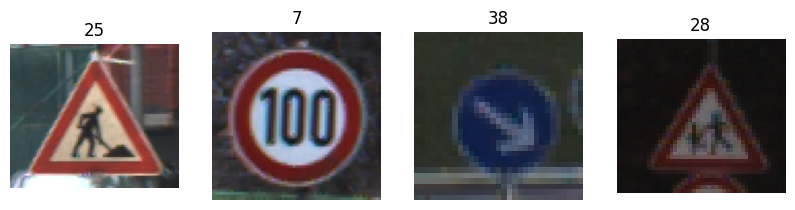

In [64]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def show_images_from_folders(root_dir, num_images=4):
    """
    Displays a specified number of images randomly chosen from different class folders in a given directory.

    Parameters:
    - root_dir (str): The directory containing class subdirectories with images.
    - num_images (int): The number of images to display.
    """
    folders = [os.path.join(root_dir, folder) for folder in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, folder))]
    selected_images = []

    # Randomly select images from folders
    while len(selected_images) < num_images:
        folder = random.choice(folders)
        image_file = random.choice(os.listdir(folder))
        image_path = os.path.join(folder, image_file)
        if os.path.isfile(image_path):
            selected_images.append(image_path)
        if len(folders) == len(selected_images):  # Prevents infinite loop if there are not enough unique images
            break

    # Plotting the images
    plt.figure(figsize=(10, 10))
    for idx, image_path in enumerate(selected_images):
        plt.subplot(1, num_images, idx + 1)
        img = Image.open(image_path)
        plt.imshow(img)
        plt.title(image_path.split('/')[-2])  # Displays the class folder as title
        plt.axis('off')
    plt.show()

# Usage
show_images_from_folders('Test_organized', num_images=4)



# Sources:
- Generative AI was utilized for Debugging, code improvement, create loop to remove deffective images, sentence structure and grammar.
- https://github.com/poojahira/gtsrb-pytorch